Neural Network Training:
Correct predictions: 101 out of 105. Accuracy: 96.2%.
Neural Network Testing:
Correct predictions: 45 out of 45. Accuracy: 100.0%.
Cost function variation during gradient descent:


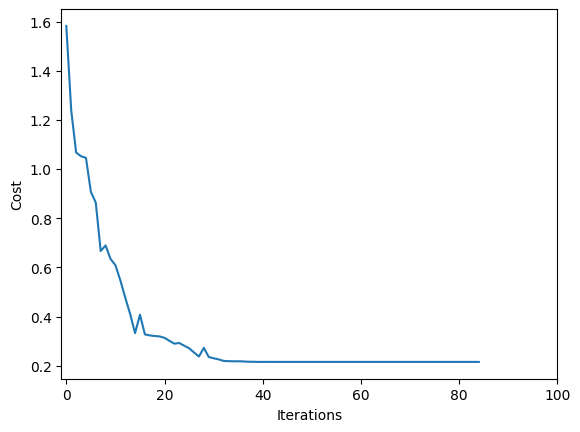

In [ ]:
# The first module, pandas, will help us load the data. With the second module,
# we will obtain an optimization method based on gradient descent.

import pandas as pd
from scipy.optimize import fmin_cg
import numpy as np
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt

# Define the sigmoid function.
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

# Define the derivative of the sigmoid function.
def sigmoid_derivative(z):
    g = 1.0 / (1.0 + np.exp(-z))
    return np.multiply(g, (1 - g))

# Load the complete dataset and define the training (X_entr, Y_entr) and test (X_test, Y_test) matrices.
# To get Y matrices of dimensions 3x105 and 3x45, we have used the y vectors.
iris = load_iris()
X_total = np.transpose(iris.data)
Y_total = iris.target

X_entr = np.zeros((4, 105))
for i in range(3):
    for j in range(35):
        X_entr[:, j + i * 35] = X_total[:, j + 50 * i]

X_test = np.zeros((4, 45))
for i in range(3):
    for j in range(15):
        X_test[:, j + i * 15] = X_total[:, 35 + j + 50 * i]

y_vect_entr = np.zeros(105)
for i in range(3):
    for j in range(35):
        y_vect_entr[j + i * 35] = Y_total[j + 50 * i]

y_vect_test = np.zeros(45)
for i in range(3):
    for j in range(15):
        y_vect_test[j + i * 15] = Y_total[35 + j + 50 * i]

Y_entr = np.zeros((3, 105))
for j in range(105):
    if y_vect_entr[j] == 0:
        Y_entr[0, j] = 1
    elif y_vect_entr[j] == 1:
        Y_entr[1, j] = 1
    else:
        Y_entr[2, j] = 1

Y_test = np.zeros((3, 45))
for j in range(45):
    if y_vect_test[j] == 0:
        Y_test[0, j] = 1
    elif y_vect_test[j] == 1:
        Y_test[1, j] = 1
    else:
        Y_test[2, j] = 1

class NeuralNetwork:

    def __init__(self, layers):
        # Initialize variables useful for the class. self.J will store the cost function values
        # to later plot them.
        self.layers = layers
        self.n = layers[0]
        self.len = len(self.layers)

        # Calculate the number of connections (weights) between each layer.
        self.connection_thetas = []
        for k in range(self.len - 1):
            connection = (self.layers[k] + 1) * self.layers[k + 1]
            self.connection_thetas.append(connection)
        self.total_connections = sum(self.connection_thetas)
        self.J = []

    def feedforward(self, Thetas_vector, X):
        # Perform forward propagation to calculate the activations of each layer.
        Thetas = self.reshape_thetas(Thetas_vector)
        ones = np.ones((1, X.shape[1]))

        self.A = [X]  # Activations for each layer.
        self.A_raw = [X]  # Activations before applying sigmoid.
        for i in range(self.len - 1):
            a = np.vstack((ones, self.A[i]))
            z = Thetas[i] @ a
            self.A_raw.append(z)
            next_activation = sigmoid(z)
            self.A.append(next_activation)
        return self.A

    def reshape_thetas(self, Thetas_vector):
        # Reshape a flattened weight vector into individual matrices for each layer.
        self.theta_list = []
        Theta1 = Thetas_vector[:(self.layers[0] + 1) * self.layers[1]]
        Theta1 = np.reshape(Theta1, (self.layers[1], (self.layers[0] + 1)))
        self.theta_list.append(Theta1)
        for k in range(self.len - 2):
            Theta = Thetas_vector[(self.layers[k] + 1) * self.layers[k + 1]:
                                  ((self.layers[k] + 1) * self.layers[k + 1] + (self.layers[k + 1] + 1) * self.layers[k + 2])]
            Theta = np.reshape(Theta, (self.layers[k + 2], (self.layers[k + 1] + 1)))
            self.theta_list.append(Theta)
        return self.theta_list

    def calculate_cost(self, Thetas_vector, X, Y):
        # Calculate the cost function value using mean squared error.
        h = self.feedforward(Thetas_vector, X)[-1]
        J = 1.0 / X.shape[1] * np.sum(np.power(Y - h, 2))
        self.J.append(J)
        return self.J[-1]

    def backpropagation(self, Thetas_vector, X, Y):
        # Perform backpropagation to compute the gradients.
        self.deltas = []  # Errors for each layer.
        self.Deltas = []  # Weight updates for each layer.

        Thetas = self.reshape_thetas(Thetas_vector)
        A = self.feedforward(Thetas_vector, X)
        H = A[-1]
        final_delta = H - Y
        self.deltas.append(final_delta)
        ones = np.ones((1, X.shape[1]))

        for i in range(self.len - 2):
            a = np.vstack((ones, self.A_raw[-i - 3]))
            z = Thetas[-i - 2] @ a
            z = sigmoid_derivative(z)
            z = np.vstack((ones, z))
            delta = np.multiply(np.transpose(Thetas[-i - 1]) @ self.deltas[0], z)
            delta = delta[1:]
            self.deltas.insert(0, delta)

        for k in range(self.len - 1):
            A[-k - 2] = np.vstack((ones, A[-k - 2]))
            Delta = self.deltas[-k - 1] @ np.transpose(A[-k - 2])
            self.Deltas.insert(0, Delta)

        self.grad = self.Deltas[0].flatten()
        for i in range(1, len(self.Deltas)):
            self.grad = np.concatenate((self.grad, self.Deltas[i].flatten()))
        self.grad = 1 / X.shape[1] * self.grad
        return self.grad

    def train_nn(self, X, Y):
        # Train the neural network using gradient descent.
        Thetas_vector = np.random.uniform(-1, 1, (self.total_connections))
        self.result = fmin_cg(self.calculate_cost, x0=Thetas_vector, fprime=self.backpropagation,
                              args=(X, Y), maxiter=100, disp=False, full_output=True)
        return self.result[0]

    def evaluate(self, X, y_vector, Thetas_vector_optm):
        # Evaluate the trained neural network's accuracy.
        predictions = self.feedforward(Thetas_vector_optm, X)[-1]
        prediction_classes = np.argmax(predictions, axis=0)
        correct = np.sum(prediction_classes == y_vector)
        accuracy = round(correct * 100 / X.shape[1], 1)
        print(f"Correct predictions: {correct} out of {y_vector.size}. Accuracy: {accuracy}%.")
        return accuracy

# Define the neural network with 3 layers: input (4 nodes) and output (3 nodes).
Neural_Network = NeuralNetwork([4, 3])

Thetas_vect_optm = Neural_Network.train_nn(X_entr, Y_entr)

# Evaluate the neural network on the training and test datasets.
print("Neural Network Training:")
training_accuracy = Neural_Network.evaluate(X_entr, y_vect_entr, Thetas_vect_optm)

print("Neural Network Testing:")
testing_accuracy = Neural_Network.evaluate(X_test, y_vect_test, Thetas_vect_optm)

# Plot the variation of the cost function over the iterations.
print("Cost function variation during gradient descent:")
costs = Neural_Network.J
x = range(len(costs))

plt.plot(x, costs)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.xlim(-1, 100)
plt.show()
